In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/.DS_Store
/kaggle/input/playground-series-s4e10/test.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/sample_submission.csv


**Importing the libraries and loading the dataset**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import Pool, CatBoostClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
import optuna
from optuna.samplers import TPESampler
import warnings
import shap
warnings.filterwarnings("ignore")

In [3]:
df_train = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
df_test  = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
df_sub = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

In [4]:
df_train.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


In [5]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
id,58645.0,29322.000000,16929.497605,0.00,14661.00,29322.00,43983.00,58644.00
person_age,58645.0,27.550857,6.033216,20.00,23.00,26.00,30.00,123.00
person_income,58645.0,64046.172871,37931.106978,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_amnt,58645.0,9217.556518,5563.807384,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645.0,0.159238,0.091692,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.00,3.00,4.00,8.00,30.00
loan_status,58645.0,0.142382,0.349445,0.00,0.00,0.00,0.00,1.00


In [6]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [7]:
#check the NA counts
df_train.isna().sum()

id                            0
person_age                    0
person_income                 0
person_home_ownership         0
person_emp_length             0
loan_intent                   0
loan_grade                    0
loan_amnt                     0
loan_int_rate                 0
loan_percent_income           0
cb_person_default_on_file     0
cb_person_cred_hist_length    0
loan_status                   0
dtype: int64

In [8]:
#Check for Duplicate Values, drop if any

#check duplicate values
df_train.duplicated().sum()

0

In [9]:
df_train.shape

(58645, 13)

In [10]:
#Checking the number of unique values
df_train.select_dtypes(include='int64').nunique()

id                            58645
person_age                       53
person_income                  2641
loan_amnt                       545
cb_person_cred_hist_length       29
loan_status                       2
dtype: int64

In [11]:
#Checking the number of unique values
df_train.select_dtypes(include='float64').nunique()

person_emp_length       36
loan_int_rate          362
loan_percent_income     61
dtype: int64

In [12]:
#Checking the number of unique values
df_train.select_dtypes(include='object').nunique()

person_home_ownership        4
loan_intent                  6
loan_grade                   7
cb_person_default_on_file    2
dtype: int64

**1. Distribution of Numerical Variables**

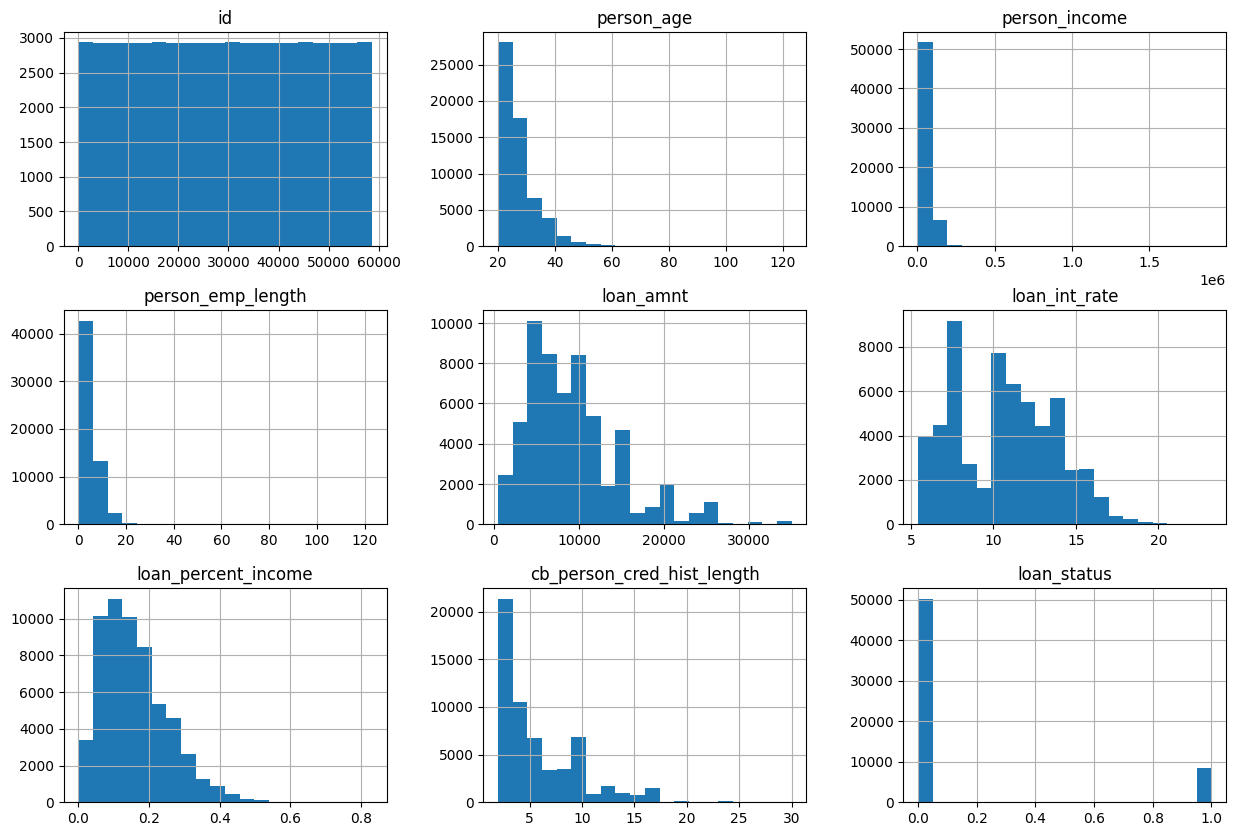

In [13]:
numeric_columns = df_train.select_dtypes(include=['int64', 'float64'])
numeric_columns.hist(bins=20, figsize=(15, 10))
plt.show()

**2. Loan Approval Rate**

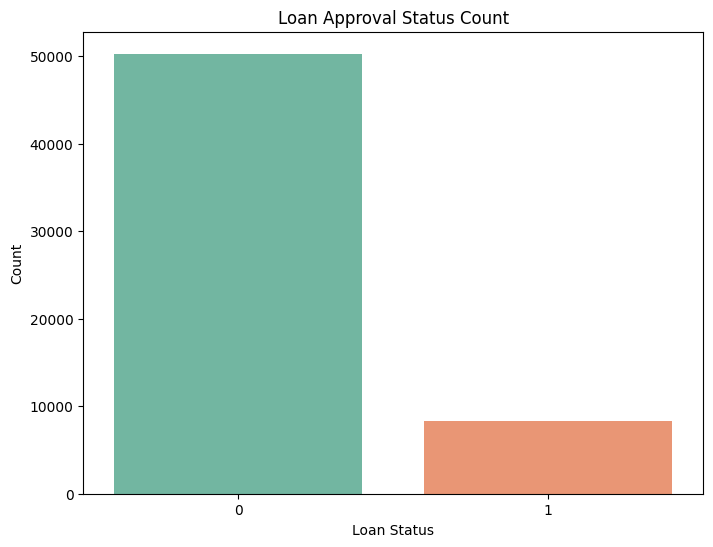

In [14]:
# Loan approval status count
plt.figure(figsize=(8, 6))
sns.countplot(x='loan_status', data=df_train, palette='Set2')
plt.title('Loan Approval Status Count')
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.show()


**3. Loan Amount vs. Income by Loan Status**

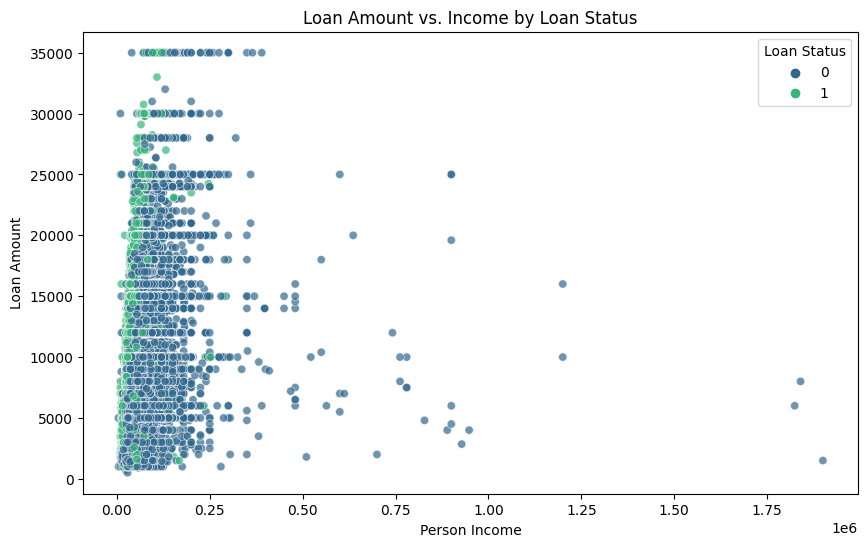

In [15]:
# Loan Amount vs. Income colored by Loan Status
plt.figure(figsize=(10, 6))
sns.scatterplot(x='person_income', y='loan_amnt', hue='loan_status', data=df_train, palette='viridis', alpha=0.7)
plt.title('Loan Amount vs. Income by Loan Status')
plt.xlabel('Person Income')
plt.ylabel('Loan Amount')
plt.legend(title='Loan Status', loc='upper right')
plt.show()


**4. Loan Intent Distribution**

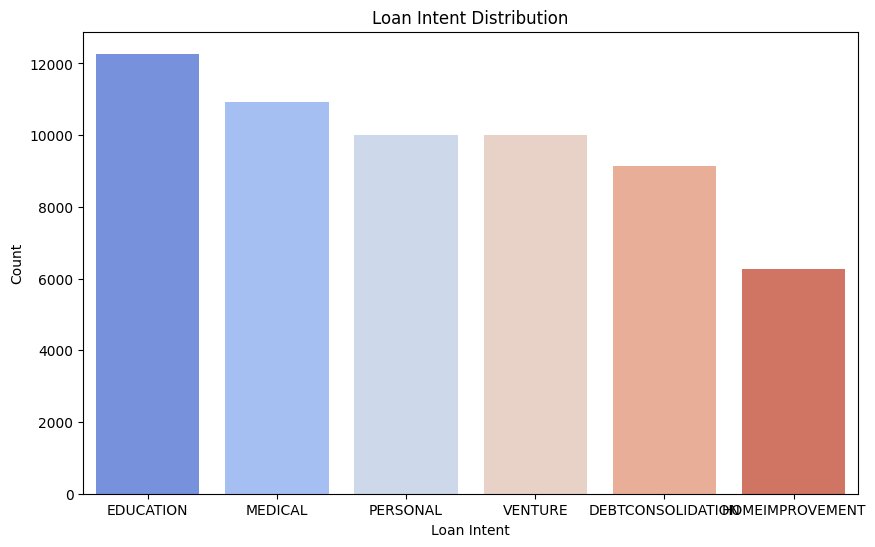

In [16]:
# Count of loan intents
plt.figure(figsize=(10, 6))
sns.countplot(x='loan_intent', data=df_train, palette='coolwarm')
plt.title('Loan Intent Distribution')
plt.xlabel('Loan Intent')
plt.ylabel('Count')
plt.show()


**5. Loan Grade Distribution by Loan Status**

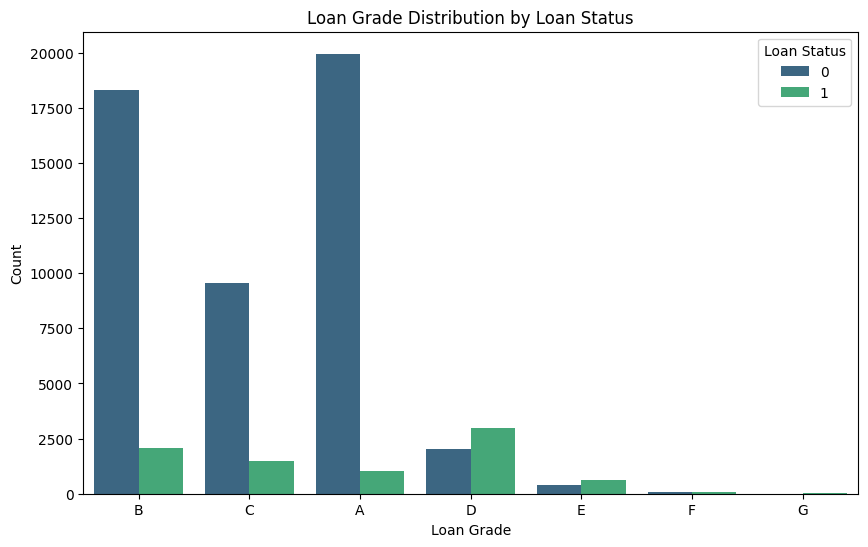

In [17]:
# Loan grade by loan status
plt.figure(figsize=(10, 6))
sns.countplot(x='loan_grade', hue='loan_status', data=df_train, palette='viridis')
plt.title('Loan Grade Distribution by Loan Status')
plt.xlabel('Loan Grade')
plt.ylabel('Count')
plt.legend(title='Loan Status')
plt.show()


**6. Correlation Heatmap for Numerical Variables**

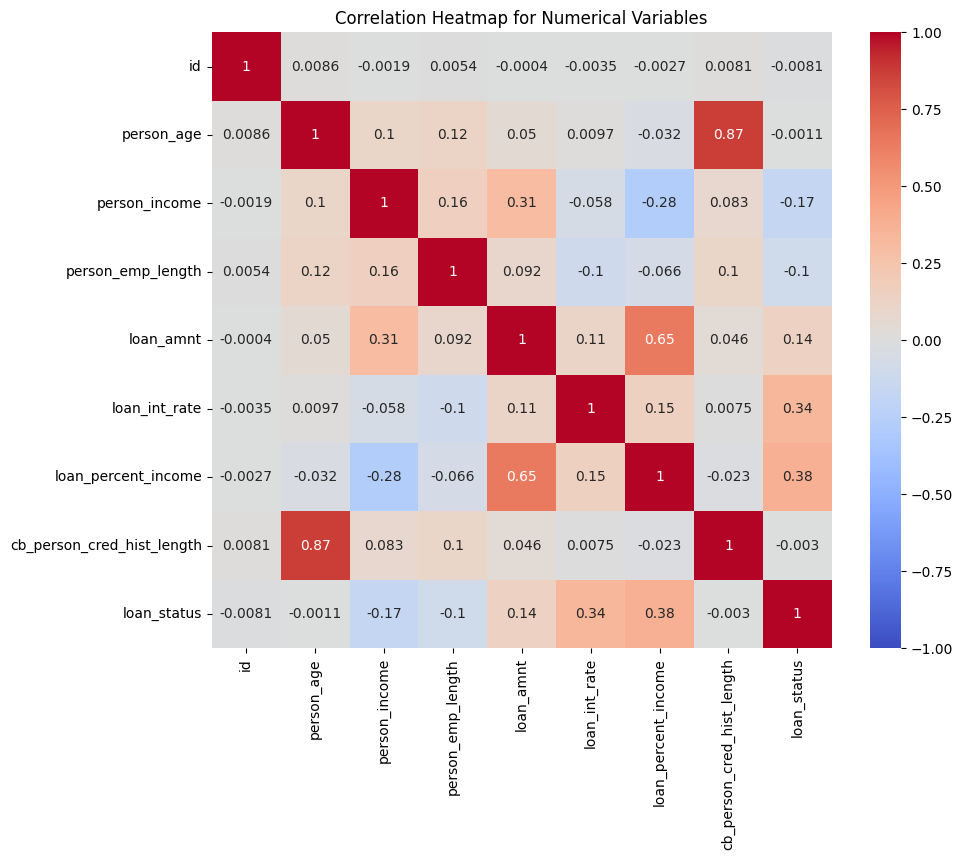

In [18]:
# Correlation heatmap
plt.figure(figsize=(10, 8))
corr = numeric_columns.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Numerical Variables")
plt.show()


**7. Loan Interest Rate Distribution by Loan Grade**

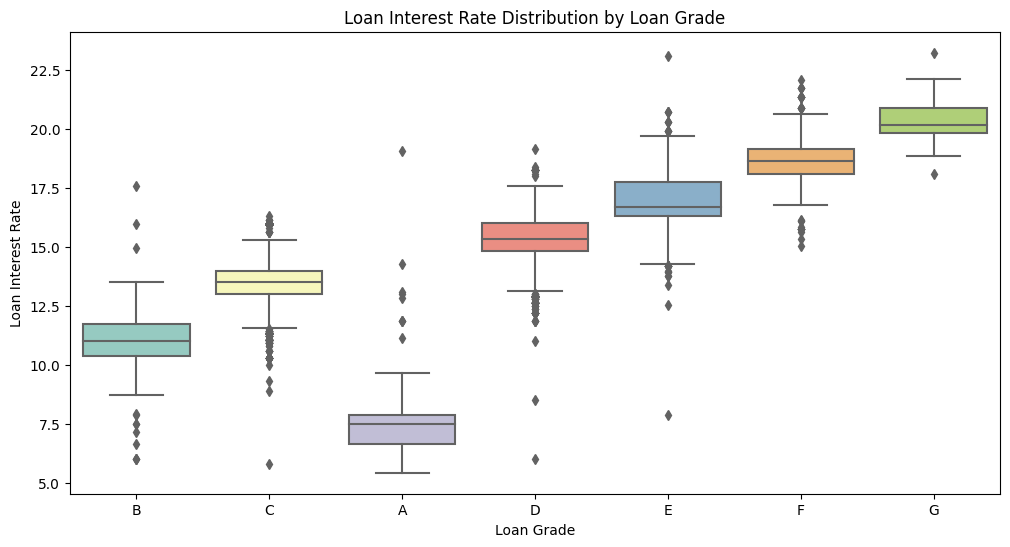

In [19]:
# Loan interest rate by loan grade
plt.figure(figsize=(12, 6))
sns.boxplot(x='loan_grade', y='loan_int_rate', data=df_train, palette='Set3')
plt.title('Loan Interest Rate Distribution by Loan Grade')
plt.xlabel('Loan Grade')
plt.ylabel('Loan Interest Rate')
plt.show()


In [20]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Copy data to avoid modifying the original DataFrame
df = df_train.copy()

# Encoding 'cb_person_default_on_file' with Label Encoding as it's binary (Y/N)
df['cb_person_default_on_file'] = LabelEncoder().fit_transform(df['cb_person_default_on_file'])

# One-hot encoding for remaining categorical variables
df = pd.get_dummies(df, columns=['person_home_ownership', 'loan_intent', 'loan_grade'], drop_first=True)

# Drop the 'id' column as it is not needed for modeling
df = df.drop(columns=['id'])

# Separate features and target variable
X = df.drop('loan_status', axis=1)
y = df['loan_status']

# Split into train and test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Print shapes of the resulting datasets to verify
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (46916, 22)
X_test shape: (11729, 22)
y_train shape: (46916,)
y_test shape: (11729,)


**check class imbalace**

In [21]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Check class distribution
class_distribution = y_train.value_counts()
print("Class Distribution:")
print(class_distribution)

# Check the imbalance ratio (ratio of the majority class to the minority class)
imbalance_ratio = class_distribution[0] / class_distribution[1]
print("Imbalance Ratio:", imbalance_ratio)

# If the imbalance ratio is greater than a threshold (e.g., 2), apply SMOTE
threshold = 2
if imbalance_ratio > threshold:
    # Initialize SMOTE
    smote = SMOTE(sampling_strategy='auto', random_state=42)

    # Fit and apply SMOTE to the training data
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Check the class distribution after SMOTE
    resampled_class_distribution = y_train_resampled.value_counts()
    print("\nClass Distribution After SMOTE:")
    print(resampled_class_distribution)

    # Update the training data with the resampled data
    X_train = X_train_resampled
    y_train = y_train_resampled
    print("\nSMOTE Applied. Training data resampled.")
else:
    print("\nNo significant class imbalance. SMOTE not applied.")

# Now, the X_train and y_train data are resampled if a significant imbalance was detected.

Class Distribution:
loan_status
0    40236
1     6680
Name: count, dtype: int64
Imbalance Ratio: 6.023353293413174

Class Distribution After SMOTE:
loan_status
0    40236
1    40236
Name: count, dtype: int64

SMOTE Applied. Training data resampled.


**Model training and fit**

**code setup**

In [22]:
import optuna
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold

# Initialize Optuna study
def optimize_model(model_class, model_name, X_train, y_train, param_grid, n_trials=50):
    def objective(trial):
        # Sample parameters from the provided grid
        params = {param: trial.suggest_categorical(param, values) if isinstance(values, list) else trial.suggest_float(param, *values) 
                  for param, values in param_grid.items()}
        
        # Initialize model with sampled parameters
        model = model_class(**params)
        
        # Cross-validation setup
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        auc_scores = []
        
        # Perform cross-validation
        for train_idx, valid_idx in cv.split(X_train, y_train):
            X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
            y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]
            
            # Fit model and calculate AUC
            model.fit(X_train_fold, y_train_fold)
            y_pred = model.predict_proba(X_valid_fold)[:, 1]
            auc = roc_auc_score(y_valid_fold, y_pred)
            auc_scores.append(auc)
        
        return np.mean(auc_scores)
    
    # Create study and optimize
    study = optuna.create_study(direction='maximize', sampler=TPESampler())
    study.optimize(objective, n_trials=n_trials)
    
    print(f"Best AUC for {model_name}: {study.best_value}")
    print(f"Best parameters for {model_name}: {study.best_params}")
    
    # Train final model with best parameters
    best_model = model_class(**study.best_params)
    best_model.fit(X_train, y_train)
    
    return best_model, study.best_params, study.best_value


**Parameter Grids for Each Model**

In [23]:
# Define parameter grids for each model
param_grids = {
    "Decision Tree": {
        "criterion": ["gini", "entropy"],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10],
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10],
    },
    "Gradient Boost": {
        "learning_rate": [0.01, 0.1, 0.2],
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 10],
    },
    "Hist Gradient Boost": {
        "learning_rate": [0.01, 0.1, 0.2],
        "max_iter": [50, 100, 200],
        "max_depth": [3, 5, 10],
    },
    "LGBM": {
        "learning_rate": [0.01, 0.1, 0.2],
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20],
    },
    "Extra Trees": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20, None],
        "min_samples_split": [2, 5, 10],
    },
    "XGBoost": {
        "learning_rate": [0.01, 0.1, 0.2],
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 10],
    },
    "CatBoost": {
        "learning_rate": [0.01, 0.1, 0.2],
        "iterations": [50, 100, 200],
        "depth": [3, 5, 10],
        "verbose": [False]
    }
}


**Model Training and Tuning**

In [24]:
# Model classes dictionary
#models = {
#    "Decision Tree": DecisionTreeClassifier,
#    "Random Forest": RandomForestClassifier,
#    "Gradient Boost": GradientBoostingClassifier,
#    "Hist Gradient Boost": HistGradientBoostingClassifier,
#    "LGBM": LGBMClassifier,
#    "Extra Trees": ExtraTreesClassifier,
#    "XGBoost": XGBClassifier,
#    "CatBoost": CatBoostClassifier,
#}

# Dictionary to store results
#model_results = {}

# Iterate through models and optimize
#for model_name, model_class in models.items():
#    print(f"Optimizing {model_name}...")
#    best_model, best_params, best_score = optimize_model(model_class, model_name, X_train, y_train, param_grids[model_name])
#    model_results[model_name] = {"model": best_model, "params": best_params, "score": best_score}
#    print("\n" + "="*50 + "\n")


**Evaluating and Selecting the Best Mode**

In [25]:
# Evaluate models on test set
#for model_name, result in model_results.items():
#    best_model = result['model']
#    y_pred = best_model.predict_proba(X_test)[:, 1]
#    test_auc = roc_auc_score(y_test, y_pred)
#    print(f"{model_name} Test ROC-AUC: {test_auc}")


Best AUC for Hist Gradient Boost: 0.9918228290468589
Best parameters for Hist Gradient Boost: {'learning_rate': 0.1, 'max_iter': 200, 'max_depth': 10}

Best parameters for LGBM: {'learning_rate': 0.2, 'n_estimators': 200, 'max_depth': 10}. 
Best AUC for LGBM: 0.9925920222876525.

Best AUC for Extra Trees: 0.9875318873232569
Best parameters for Extra Trees: {'n_estimators': 100, 'max_depth': None, 'min_samples_split': 2}

Best AUC for XGBoost: 0.9923447940956382
Best parameters for XGBoost: {'learning_rate': 0.2, 'n_estimators': 200, 'max_depth': 5}

Best AUC for CatBoost: 0.9914224320939417
Best parameters for CatBoost: {'learning_rate': 0.2, 'iterations': 200, 'depth': 10, 'verbose': False}

Best AUC for Decision Tree: 0.9717241110675072
Best parameters for Decision Tree: {'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 10}

Best AUC for Random Forest: 0.9901834696446098
Best parameters for Random Forest: {'n_estimators': 200, 'max_depth': None, 'min_samples_split': 5}

Best AUC for Hist Gradient Boost: 0.9918228290468589
Best parameters for Hist Gradient Boost: {'learning_rate': 0.1, 'max_iter': 200, 'max_depth': 10}

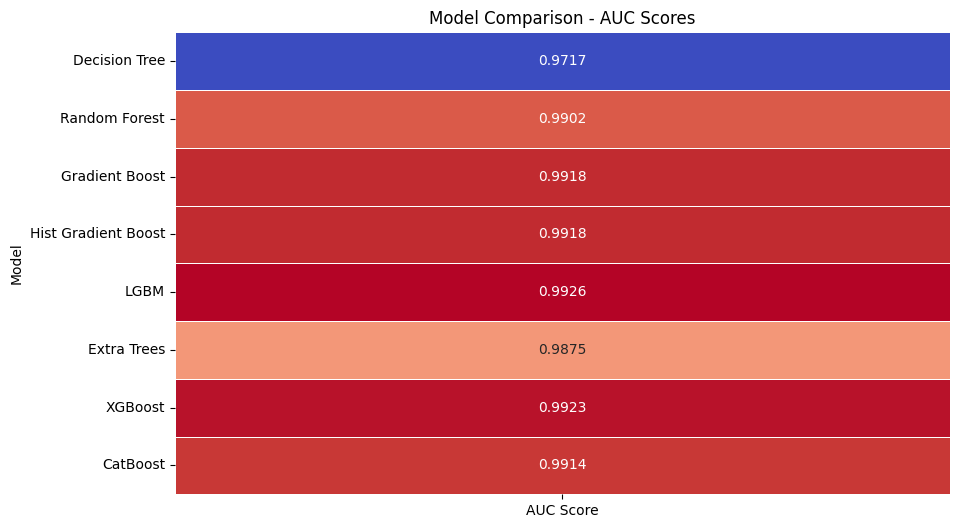

In [26]:
# Model AUC scores
model_data = {
    "Model": [
        "Decision Tree", "Random Forest", "Gradient Boost",
        "Hist Gradient Boost", "LGBM", "Extra Trees", "XGBoost", "CatBoost"
    ],
    "AUC Score": [
        0.9717, 0.9902, 0.9918,
        0.9918, 0.9926, 0.9875, 0.9923, 0.9914
    ]
}

# Create DataFrame and set 'Model' as index
model_df = pd.DataFrame(model_data)
model_auc_df = model_df.set_index("Model")[["AUC Score"]]

# Plotting heatmap with "coolwarm" color scheme
plt.figure(figsize=(10, 6))
sns.heatmap(model_auc_df, annot=True, cmap="coolwarm", fmt=".4f", cbar=False, linewidths=0.5)
plt.title("Model Comparison - AUC Scores")
plt.xlabel("")
plt.ylabel("Model")
plt.show()


In [27]:
import pandas as pd
from lightgbm import LGBMClassifier

# Load the train, test, and sample submission files
train_data = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')
sample_submission = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')

# Drop the 'id' column from train_data only, as it's not needed for training
train_data = train_data.drop(columns=['id'])

# Separate features and target variable in training data
X_train = pd.get_dummies(train_data.drop(columns=['loan_status']), drop_first=True)
y_train = train_data['loan_status']

# One-hot encode test data to match training features
X_test = pd.get_dummies(test_data.drop(columns=['id']), drop_first=True)
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

# Initialize and train the best model
best_lgbm_model = LGBMClassifier(
    colsample_bytree=0.5037422102988546,
    learning_rate=0.06135610511225369,
    max_depth=17,
    min_child_samples=39,
    n_estimators=405,
    num_leaves=92,
    reg_alpha=6.104444423024194e-05,
    reg_lambda=1.9282683222050507,
    subsample=0.755548427932435
)
best_lgbm_model.fit(X_train, y_train)

# Make predictions for the test set
test_predictions_proba = best_lgbm_model.predict_proba(X_test)[:, 1]
test_predictions = (test_predictions_proba >= 0.5).astype(int)



[LightGBM] [Info] Number of positive: 8350, number of negative: 50295
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008645 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 852
[LightGBM] [Info] Number of data points in the train set: 58645, number of used features: 21
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.142382 -> initscore=-1.795644
[LightGBM] [Info] Start training from score -1.795644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

In [28]:
# Create the submission DataFrame based on the sample_submission structure
submission = sample_submission.copy()
submission['loan_status'] = test_predictions

# Save to CSV in the required format
submission.to_csv("/kaggle/output/submission.csv", index=False)
print("Submission file created successfully as 'submission.csv'")


Submission file created successfully as 'submission.csv'
